In [1]:
%cd /kaggle/working

import os

from hydra import compose, initialize
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="../experiments/032_feature_channel"):
    cfg = compose(
        config_name="config.yaml", overrides=["debug=True"], return_hydra_config=True
    )

/kaggle/working


In [2]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [3]:
df = pl.read_parquet("input/train.parquet", n_rows=10000)

In [190]:
(df[:, 181:241] == 0).sum()

state_q0003_0,state_q0003_1,state_q0003_2,state_q0003_3,state_q0003_4,state_q0003_5,state_q0003_6,state_q0003_7,state_q0003_8,state_q0003_9,state_q0003_10,state_q0003_11,state_q0003_12,state_q0003_13,state_q0003_14,state_q0003_15,state_q0003_16,state_q0003_17,state_q0003_18,state_q0003_19,state_q0003_20,state_q0003_21,state_q0003_22,state_q0003_23,state_q0003_24,state_q0003_25,state_q0003_26,state_q0003_27,state_q0003_28,state_q0003_29,state_q0003_30,state_q0003_31,state_q0003_32,state_q0003_33,state_q0003_34,state_q0003_35,state_q0003_36,state_q0003_37,state_q0003_38,state_q0003_39,state_q0003_40,state_q0003_41,state_q0003_42,state_q0003_43,state_q0003_44,state_q0003_45,state_q0003_46,state_q0003_47,state_q0003_48,state_q0003_49,state_q0003_50,state_q0003_51,state_q0003_52,state_q0003_53,state_q0003_54,state_q0003_55,state_q0003_56,state_q0003_57,state_q0003_58,state_q0003_59
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1546,1554,1758,1861,816,1396,1981,1945,1841,1579,1380,1221,1192,1267,1326,1426,1415,1374,1256,1137,1069,982,951,914,1344,1749,2058,2210,2280,2220,2187,2187,2376,2474,2435,2458,2430,2556,2784,2976,3146,3276,3366,3457,3494,3528


In [ ]:
# compact boxplot of all features - train only
n_plot_rows = 10
n_plot_cols = 60
n = len(features_num)
for i in range(n_plot_rows):
    a = n_plot_cols * i + 1
    b = min(n_plot_cols * i + n_plot_cols, n)
    print("Columns", a, "to", b)
    df_train.to_pandas().iloc[:, a : (b + 1)].plot(kind="box", figsize=(15, 5))
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()

In [153]:
import xarray as xr

grid_path = "/kaggle/working/misc/grid_info/ClimSim_low-res_grid-info.nc"
grid_info = xr.open_dataset(grid_path)
hyam = grid_info["hyam"].to_numpy()
hybm = grid_info["hybm"].to_numpy()
hyai = grid_info["hyai"].to_numpy()
hybi = grid_info["hybi"].to_numpy()

In [154]:
p0 = 1e5
ps = df["state_ps"].to_numpy()
pressures_array = hyam * p0 + hybm[None, :] * ps[:, None]

In [169]:
p0 = 1e5
ps = df["state_ps"].to_numpy()
pressures_array = hyai * p0 + hybi[None, :] * ps[:, None]
pressures_array = np.diff(pressures_array, n=1)
pressures_array

array([[   4.49334817,    8.05875326,   14.30424243, ..., 1451.11266244,
        1471.68984952, 1493.34682294],
       [   4.49334817,    8.05875326,   14.30424243, ..., 1456.22305609,
        1476.87270999, 1498.60595293],
       [   4.49334817,    8.05875326,   14.30424243, ..., 1414.94749233,
        1435.01184709, 1456.12907736],
       ...,
       [   4.49334817,    8.05875326,   14.30424243, ..., 1423.77411798,
        1443.96363679, 1465.21259907],
       [   4.49334817,    8.05875326,   14.30424243, ..., 1325.05369737,
        1343.84333274, 1363.61895282],
       [   4.49334817,    8.05875326,   14.30424243, ..., 1398.0549911 ,
        1417.87980542, 1438.74492539]])

In [157]:
import numpy as np


def calculate_saturation_vapor_pressure(T):
    """温度から飽和水蒸気圧を計算する (Boltonの式)"""
    return 6.112 * np.exp((17.67 * T) / (T + 243.5))


def calculate_saturation_specific_humidity(es, P):
    """飽和水蒸気圧と気圧から飽和比湿を計算する"""
    return 0.622 * es / np.maximum(es, P - es)

In [158]:
def calculate_saturation_vapor_pressure(t):
    a0 = 6.105851
    a1 = 0.4440316
    a2 = 0.1430341e-1
    a3 = 0.2641412e-3
    a4 = 0.2995057e-5
    a5 = 0.2031998e-7
    a6 = 0.6936113e-10
    a7 = 0.2564861e-13
    a8 = -0.3704404e-15

    dtt = t - 273.16
    esatw = a0 + dtt * (
        a1
        + dtt
        * (
            a2
            + dtt * (a3 + dtt * (a4 + dtt * (a5 + dtt * (a6 + dtt * (a7 + a8 * dtt)))))
        )
    )

    index = dtt <= -80.0
    esatw[index] = (
        2.0
        * 0.01
        * np.exp(9.550426 - 5723.265 / t + 3.53068 * np.log(t) - 0.00728332 * t)
    )[index]
    return esatw


def calculate_saturation_vapor_pressure_ice(t):
    a0 = 6.11147274
    a1 = 0.503160820
    a2 = 0.188439774e-1
    a3 = 0.420895665e-3
    a4 = 0.615021634e-5
    a5 = 0.602588177e-7
    a6 = 0.385852041e-9
    a7 = 0.146898966e-11
    a8 = 0.252751365e-14

    dtt = t - 273.16
    esati = a0 + dtt * (
        a1
        + dtt
        * (
            a2
            + dtt * (a3 + dtt * (a4 + dtt * (a5 + dtt * (a6 + dtt * (a7 + a8 * dtt)))))
        )
    )

    index = dtt <= -80.0
    esati[index] = (
        0.01 * np.exp(9.550426 - 5723.265 / t + 3.53068 * np.log(t) - 0.00728332 * t)
    )[index]
    return esati

In [159]:
h = 46
es = calculate_saturation_vapor_pressure(df[f"state_t_{h}"].to_numpy())
saturation_specific_humidity = calculate_saturation_specific_humidity(
    es, df["state_ps"].to_numpy()  # pressures_array[:, h]  #
)

In [160]:
es

array([10.37029262,  8.28199079, 12.96104699, ..., 12.62299437,
       15.64797257, 13.68847618])

In [161]:
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns

In [162]:
df_pandas = df.to_pandas()

/tmp/ipykernel_498/2148881899.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/tmp/ipykernel_498/2148881899.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


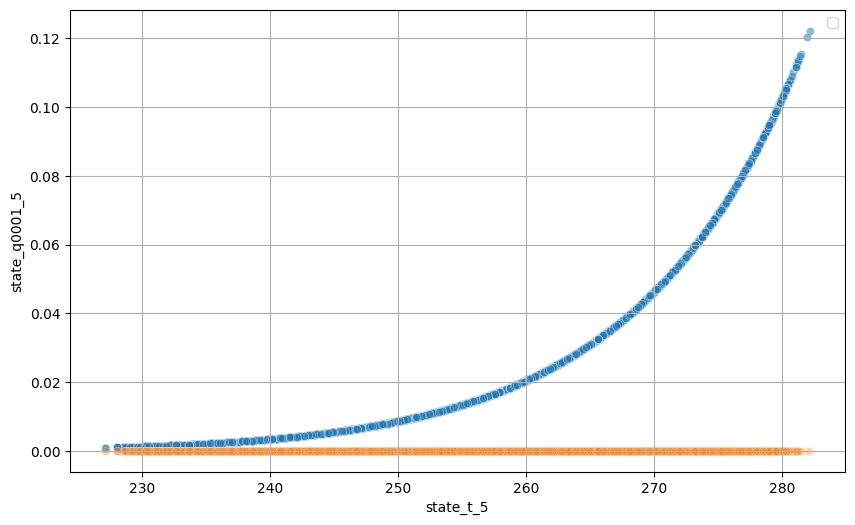

In [175]:
h = 5
col1 = f"state_t_{h}"  # state_t_46, state_q0001_46, state_q0002_46, state_q0003_46

es = calculate_saturation_vapor_pressure(df[col1].to_numpy())
saturation_specific_humidity = calculate_saturation_specific_humidity(
    es, pressures_array[:, h]  # df["state_ps"].to_numpy()
)


df_pandas["tmp"] = saturation_specific_humidity

# 散布図を描画
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pandas,
    x=col1,
    y="tmp",
    palette="blue",
    alpha=0.5,
)

sns.scatterplot(
    data=df_pandas,
    x=col1,
    y=f"state_q0001_{h}",
    palette="red",
    alpha=0.2,
)

plt.xlabel(col1)
plt.ylabel(f"state_q0001_{h}")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_498/2463919538.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


<Axes: xlabel='state_t_43', ylabel='state_q0002_43'>

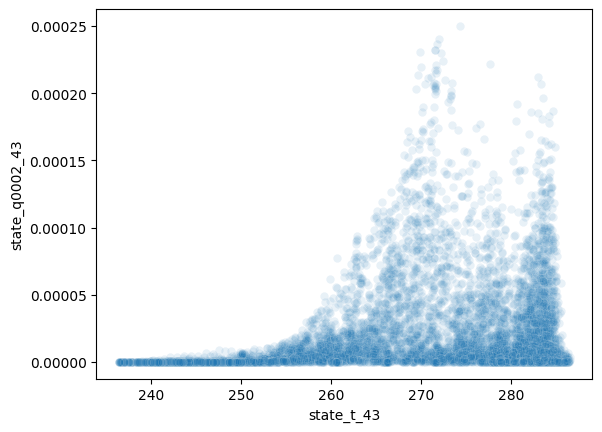

In [187]:
h = 43
col1 = f"state_t_{h}"  # state_t_46, state_q0001_46, state_q0002_46, state_q0003_46

sns.scatterplot(
    data=df_pandas,
    x=col1,
    y=f"state_q0002_{h}",
    palette="red",
    alpha=0.1,
)

In [119]:
esi = calculate_saturation_vapor_pressure_ice(df[f"state_t_{h}"].to_numpy())
saturation_specific_humidity_ice = calculate_saturation_specific_humidity(
    esi, pressures_array[:, h]  # df["state_ps"].to_numpy()
)

/tmp/ipykernel_498/2614583691.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/tmp/ipykernel_498/2614583691.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


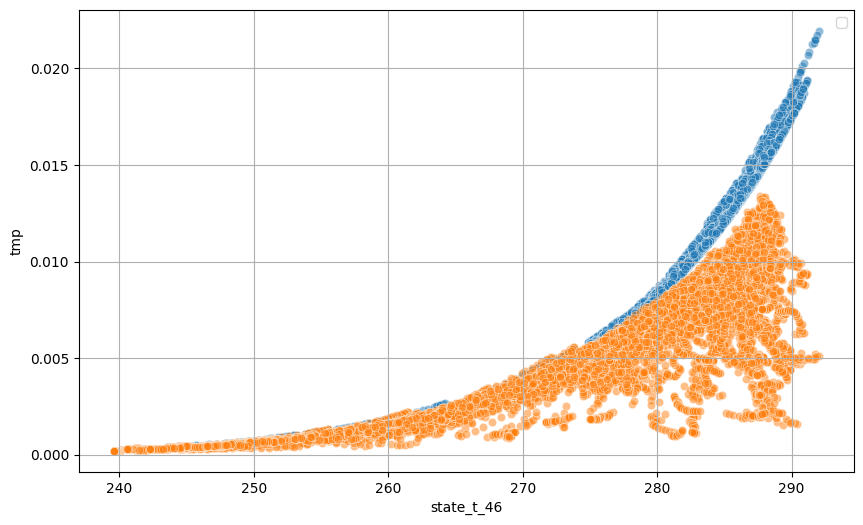

In [122]:
col1 = "state_t_46"  # state_t_46, state_q0001_46, state_q0002_46, state_q0003_46

df_pandas["tmp"] = saturation_specific_humidity_ice * 100

# 散布図を描画
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pandas,
    x=col1,
    y="tmp",
    palette="blue",
    alpha=0.5,
)

sns.scatterplot(
    data=df_pandas,
    x=col1,
    y="state_q0001_46",
    palette="red",
    alpha=0.5,
)

plt.xlabel(col1)
plt.ylabel("tmp")
plt.legend()
plt.grid(True)
plt.show()